In [1]:
import numpy as np
import pandas as pd
import itertools

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


# Data Setup

In [2]:
def parseCSV(file):
    data = pd.read_csv(file)
    data = data
    data["Word"]= data["Word"].str.lower()
    data['Index'] = np.arange(len(data))
    return data[['Word', 'Language', "Index"]]

In [3]:
class CNN():
    def __init__(self, train_data_source, test_data_source):
        self.train_df = train_data_source
        self.test_df = test_data_source

        self.x_train = np.array(self.train_df["Word"])
        self.x_test = np.array(self.test_df["Word"])

        CHAR_STRING = 'abcdefghijklmnopqrstuvwxyzáéíóúüñàèìòùçâêîôûëïäöß()-āēīōū’ā̆ē̆ī̆ō̆ăĭḗū́u̯ṇ̃þʒ¹²/\ :;"!?¿¡".'
        char_dict = {}

        for i, char, in enumerate(CHAR_STRING):
            char_dict[char] = i + 1

        #print(char_dict)

        self.tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
        self.tk.fit_on_texts(self.x_train)

        self.tk.word_index = char_dict.copy()
        self.tk.word_index[self.tk.oov_token] = max(char_dict.values()) + 1

        train_sequences = self.tk.texts_to_sequences(self.x_train)
        test_texts = self.tk.texts_to_sequences(self.x_test)

        #print(tk.word_index)

        # Padding
        train_data = pad_sequences(train_sequences, maxlen=1014, padding='post')
        test_data = pad_sequences(test_texts, maxlen=1014, padding='post')

        # Convert to numpy array
        train_data = np.array(train_data, dtype='float32')
        test_data = np.array(test_data, dtype='float32')

        self.class2indexes = dict((l, i) for i, l in enumerate(set(self.train_df["Language"])))
        self.index2class = dict((i, l) for i, l in enumerate(set(self.train_df["Language"])))

#         print(self.class2indexes)

        train_classes = self.train_df["Language"]
        train_class_list = [self.class2indexes[x] for x in train_classes]

        test_classes = self.test_df["Language"]
        test_class_list = [self.class2indexes[x] for x in test_classes]

        train_classes = to_categorical(train_class_list)
        test_classes = to_categorical(test_class_list) #converts class to binary class martix 

        vocab_size = 93
#         print(vocab_size)

        embedding_weights = [] 
        embedding_weights.append(np.zeros(vocab_size))

        for i in range(vocab_size):
            onehot = np.zeros(vocab_size)
            onehot[i] = 1
            embedding_weights.append(onehot)


        embedding_weights = np.array(embedding_weights)
        # print(embedding_weights.shape)
        # print(embedding_weights)
#         print('Load')

        # Model Construction

        #parameters
        input_size = 1014
        embedding_size = 93
        conv_layers = [[256, 7, 3],
                        [256, 7, 3],
                        [256, 3, -1],
                        [256, 3, -1],
                        [256, 3, -1],
                        [256, 3, 3]]

        fully_connected_layers = [1024,1024]
        nums_of_classes = 7
        dropout_p = 0.5
        optimizer = "adam"
        loss = "categorical_crossentropy"

        # Embedding layer Initialization
        embedding_layer = Embedding(vocab_size + 1, embedding_size,
                                    input_length=input_size,
                                    weights=[embedding_weights])


        # Input
        inputs = Input(shape=(input_size,), 
                    name='input', dtype='int64')  # shape=(?, 1014)

        x = embedding_layer(inputs)
        #conv 
        for filter_num, filter_size, pooling_size in conv_layers:
            x = Conv1D(filter_num, filter_size)(x) #data_format = 'channels_first'
            x = Activation('relu')(x)
            if pooling_size != -1:
                x = MaxPooling1D(pool_size=pooling_size)(x) #prevents overfitting
        x = Flatten()(x) #turns in a martix into a 1D array 
        #Fully connected layers
        for dense_size in fully_connected_layers:
            x = Dense(dense_size, activation='relu')(x)
            x = Dropout(dropout_p)(x) #help reduce overfitting

        #Output Layer
        predictions = Dense(nums_of_classes, activation='softmax')(x)
        #Build Model
        self.model = Model(input=inputs, outputs=predictions)
        self.model.compile(optimizer=optimizer, loss=loss)
        self.model.summary()

        self.history = self.model.fit(train_data, train_classes, validation_data=(test_data, test_classes), 
                       batch_size=128, epochs=9, verbose=2)
        
    def predict(self, x_df): #used to be false 
        total_words = len(x_df.index)
        correct_predictions = 0
        
        self.ans_pred = [] # list of tuples containing (answer, prediction) for confusion matrix
        
        x_test = np.array(x_df["Word"])
        test_texts = self.tk.texts_to_sequences(x_test)
        test_data = pad_sequences(test_texts, maxlen=1014, padding='post')
        test_data = np.array(test_data, dtype='float32')
        predictions = self.model.predict(test_data)
        predict_results = predictions.argmax(axis=-1)
        
        for i in range(len(predict_results)):
#             index = x_df["Index"][i]
            answer = x_df.iloc[i]['Language']
            prediction = self.index2class[predict_results[i]]
    
            self.ans_pred.append((answer, prediction))
        
#             print(self.test_df["Word"][index])
            if answer == prediction:
                correct_predictions += 1
#             print("Language: ", self.index2class[predict_results[i]])
#             print("Probability: ", predictions[i][predict_results[i]])
                
        return correct_predictions / total_words

## Stopwords Excluded

In [4]:
csv_data = parseCSV('language_dataset.csv')

csv_data["Word"]= csv_data["Word"].str.lower() 
train_data, test_data = train_test_split(csv_data, test_size=0.2)

print('Number of Words per Language')
csv_data.groupby('Language').size()

Number of Words per Language


Language
English           898
French            942
German            884
Italian           940
Simlish           111
Spanish           919
Tolkien Elvish    876
dtype: int64

In [5]:
stop_words_excluded_cnn = CNN(train_data, test_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1014)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1014, 93)          8742      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1008, 256)         166912    
_________________________________________________________________
activation_1 (Activation)    (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 336, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 330, 256)          459008    
_________________________________________________________________
activation_2 (Activation)    (None, 330, 256)          0   

C:\Users\takri\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4456 samples, validate on 1114 samples
Epoch 1/9
 - 91s - loss: 1.8715 - val_loss: 1.7991
Epoch 2/9
 - 83s - loss: 1.6400 - val_loss: 1.4778
Epoch 3/9
 - 83s - loss: 1.3797 - val_loss: 1.4057
Epoch 4/9
 - 87s - loss: 1.2316 - val_loss: 1.2875
Epoch 5/9
 - 85s - loss: 1.1427 - val_loss: 1.2397
Epoch 6/9
 - 88s - loss: 1.0274 - val_loss: 1.2621
Epoch 7/9
 - 89s - loss: 0.9420 - val_loss: 1.2382
Epoch 8/9
 - 87s - loss: 0.9043 - val_loss: 1.2332
Epoch 9/9
 - 87s - loss: 0.8238 - val_loss: 1.2492


In [6]:
stop_words_excluded_test_acc = stop_words_excluded_cnn.predict(test_data)
stop_words_excluded_train_acc = stop_words_excluded_cnn.predict(train_data)

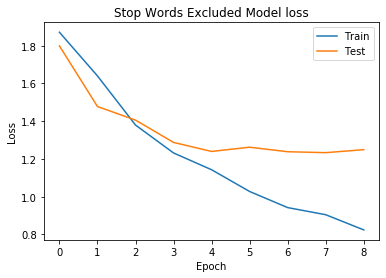

In [7]:
# Plot training & validation loss values
plt.plot(stop_words_excluded_cnn.history.history['loss'])
plt.plot(stop_words_excluded_cnn.history.history['val_loss'])
plt.title('Stop Words Excluded Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Stopwords Included

In [8]:
csv_data = parseCSV('language_dataset_with_stopwords.csv')

csv_data["Word"]= csv_data["Word"].str.lower() 
train_data, test_data = train_test_split(csv_data, test_size=0.2)

print('Number of Words per Language')
csv_data.groupby('Language').size()

Number of Words per Language


Language
English           1000
French            1000
German            1000
Italian           1000
Simlish            111
Spanish           1000
Tolkien Elvish     894
dtype: int64

In [9]:
stop_words_included_cnn = CNN(train_data, test_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1014)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1014, 93)          8742      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1008, 256)         166912    
_________________________________________________________________
activation_7 (Activation)    (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 336, 256)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 330, 256)          459008    
_________________________________________________________________
activation_8 (Activation)    (None, 330, 256)          0   

C:\Users\takri\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4804 samples, validate on 1201 samples
Epoch 1/9
 - 93s - loss: 1.8603 - val_loss: 1.7660
Epoch 2/9
 - 95s - loss: 1.6723 - val_loss: 1.5374
Epoch 3/9
 - 95s - loss: 1.4482 - val_loss: 1.3595
Epoch 4/9
 - 93s - loss: 1.2682 - val_loss: 1.2529
Epoch 5/9
 - 97s - loss: 1.1683 - val_loss: 1.2104
Epoch 6/9
 - 95s - loss: 1.0899 - val_loss: 1.2348
Epoch 7/9
 - 92s - loss: 1.0307 - val_loss: 1.1915
Epoch 8/9
 - 93s - loss: 0.9668 - val_loss: 1.1707
Epoch 9/9
 - 98s - loss: 0.9156 - val_loss: 1.1864


In [10]:
stop_words_included_test_acc = stop_words_included_cnn.predict(test_data)
stop_words_included_train_acc = stop_words_included_cnn.predict(train_data)

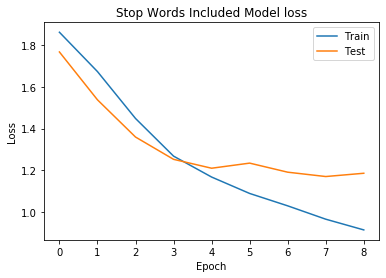

In [11]:
# Plot training & validation loss values
plt.plot(stop_words_included_cnn.history.history['loss'])
plt.plot(stop_words_included_cnn.history.history['val_loss'])
plt.title('Stop Words Included Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Difficult Words Only

In [12]:
csv_data = parseCSV('Difficult_Set.csv')

csv_data["Word"]= csv_data["Word"].str.lower() 
train_data, test_data = train_test_split(csv_data, test_size=0.2)

print('Number of Words per Language')
csv_data.groupby('Language').size()

Number of Words per Language


Language
English           882
French            790
German            862
Italian           811
Simlish           111
Spanish           821
Tolkien Elvish    893
dtype: int64

In [13]:
difficult_words_only_cnn = CNN(train_data, test_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1014)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1014, 93)          8742      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1008, 256)         166912    
_________________________________________________________________
activation_13 (Activation)   (None, 1008, 256)         0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 336, 256)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 330, 256)          459008    
_________________________________________________________________
activation_14 (Activation)   (None, 330, 256)          0   

C:\Users\takri\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4136 samples, validate on 1034 samples
Epoch 1/9
 - 82s - loss: 1.8829 - val_loss: 1.8453
Epoch 2/9
 - 85s - loss: 1.6914 - val_loss: 1.5689
Epoch 3/9
 - 93s - loss: 1.4403 - val_loss: 1.3509
Epoch 4/9
 - 91s - loss: 1.2245 - val_loss: 1.2434
Epoch 5/9
 - 83s - loss: 1.1103 - val_loss: 1.3008
Epoch 6/9
 - 85s - loss: 1.0714 - val_loss: 1.2283
Epoch 7/9
 - 84s - loss: 0.9751 - val_loss: 1.1648
Epoch 8/9
 - 85s - loss: 0.9287 - val_loss: 1.2847
Epoch 9/9
 - 85s - loss: 0.9088 - val_loss: 1.1855


In [14]:
difficult_words_only_test_acc = difficult_words_only_cnn.predict(test_data)
difficult_words_only_train_acc = difficult_words_only_cnn.predict(train_data)

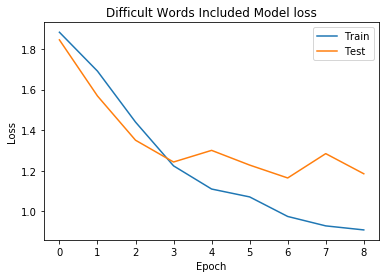

In [15]:
# Plot training & validation loss values
plt.plot(difficult_words_only_cnn.history.history['loss'])
plt.plot(difficult_words_only_cnn.history.history['val_loss'])
plt.title('Difficult Words Included Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Results

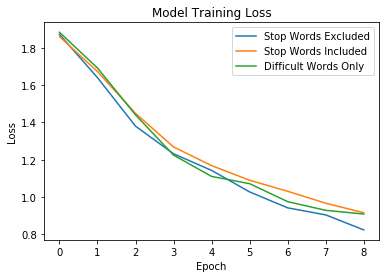

In [16]:
plt.plot(stop_words_excluded_cnn.history.history['loss'])
plt.plot(stop_words_included_cnn.history.history['loss'])
plt.plot(difficult_words_only_cnn.history.history['loss'])

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Stop Words Excluded', 'Stop Words Included', 'Difficult Words Only'], loc='upper right')
plt.show()

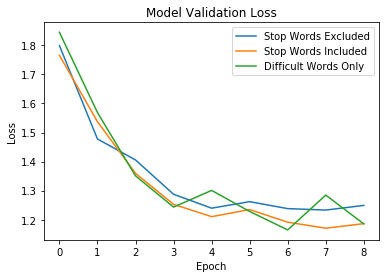

In [17]:
plt.plot(stop_words_excluded_cnn.history.history['val_loss'])
plt.plot(stop_words_included_cnn.history.history['val_loss'])
plt.plot(difficult_words_only_cnn.history.history['val_loss'])

plt.title('Model Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Stop Words Excluded', 'Stop Words Included', 'Difficult Words Only'], loc='upper right')
plt.show()

In [18]:
print('stop words excluded training data accuracy: {:.4f}%'.format(stop_words_excluded_train_acc * 100))
print('stop words excluded testing data accuracy: {:.4f}%'.format(stop_words_excluded_test_acc * 100))
print()
print('stop words included training data accuracy: {:.4f}%'.format(stop_words_included_train_acc * 100))
print('stop words included testing data accuracy: {:.4f}%'.format(stop_words_included_test_acc * 100))
print()
print('difficult words only training data accuracy: {:.4f}%'.format(difficult_words_only_train_acc * 100))
print('difficult words only testing data accuracy: {:.4f}%'.format(difficult_words_only_test_acc * 100))

stop words excluded training data accuracy: 72.4192%
stop words excluded testing data accuracy: 54.3088%

stop words included training data accuracy: 62.8226%
stop words included testing data accuracy: 51.9567%

difficult words only training data accuracy: 69.6567%
difficult words only testing data accuracy: 57.0600%


In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Language')
    plt.xlabel('Predicted Language')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

In [20]:
languages = ["English", "Spanish", "German", "Italian", "French", "Simlish", "Tolkien Elvish"]
np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.77 0.11 0.1  0.   0.   0.   0.  ]
 [0.17 0.8  0.01 0.   0.   0.01 0.01]
 [0.11 0.01 0.87 0.   0.   0.   0.01]
 [0.02 0.06 0.   0.84 0.   0.07 0.  ]
 [0.25 0.03 0.46 0.   0.   0.01 0.25]
 [0.02 0.11 0.   0.66 0.   0.21 0.  ]
 [0.02 0.   0.03 0.01 0.   0.   0.95]]


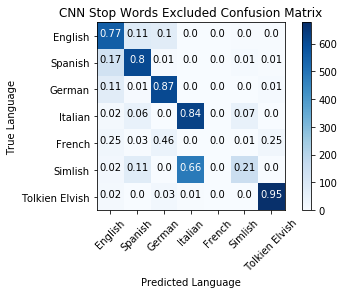

In [21]:
answers = [x[0] for x in stop_words_excluded_cnn.ans_pred]
predictions = [x[1] for x in stop_words_excluded_cnn.ans_pred]

cnf_matrix = confusion_matrix(answers, predictions)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=languages,
#                       title='Confusion matrix, without normalization')

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=languages, normalize=True,
                      title='CNN Stop Words Excluded Confusion Matrix')

plt.show()

Normalized confusion matrix
[[0.32 0.23 0.45 0.   0.   0.   0.  ]
 [0.05 0.93 0.01 0.   0.   0.01 0.  ]
 [0.09 0.05 0.86 0.   0.   0.   0.  ]
 [0.01 0.18 0.   0.63 0.   0.18 0.  ]
 [0.27 0.12 0.29 0.   0.   0.   0.31]
 [0.02 0.22 0.   0.54 0.   0.21 0.  ]
 [0.04 0.02 0.02 0.   0.   0.   0.91]]


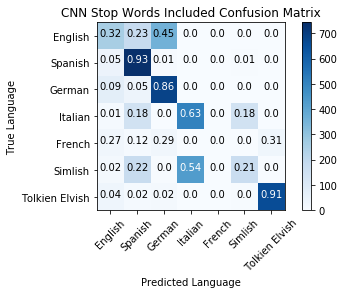

In [22]:
answers = [x[0] for x in stop_words_included_cnn.ans_pred]
predictions = [x[1] for x in stop_words_included_cnn.ans_pred]

cnf_matrix = confusion_matrix(answers, predictions)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=languages,
#                       title='Confusion matrix, without normalization')

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=languages, normalize=True,
                      title='CNN Stop Words Included Confusion Matrix')

plt.show()

Normalized confusion matrix
[[0.75 0.1  0.15 0.   0.   0.   0.  ]
 [0.11 0.83 0.   0.   0.   0.06 0.  ]
 [0.15 0.01 0.83 0.   0.   0.   0.01]
 [0.01 0.06 0.   0.82 0.   0.12 0.  ]
 [0.42 0.09 0.47 0.   0.   0.   0.02]
 [0.01 0.1  0.   0.72 0.   0.16 0.  ]
 [0.03 0.04 0.06 0.   0.   0.01 0.86]]


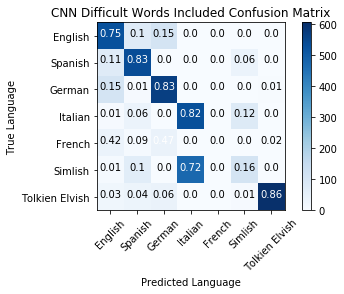

In [23]:
answers = [x[0] for x in difficult_words_only_cnn.ans_pred]
predictions = [x[1] for x in difficult_words_only_cnn.ans_pred]

cnf_matrix = confusion_matrix(answers, predictions)

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=languages, normalize=True,
                      title='CNN Difficult Words Included Confusion Matrix')

plt.show()

# Alternative Test Data

In [40]:
def predict_white_box(classifier, x_df):
    total_words = len(x_df.index)
    correct_predictions = 0

    classifier.ans_pred = [] # list of tuples containing (answer, prediction) for confusion matrix

    x_test = np.array(x_df["Word"])
    test_texts = classifier.tk.texts_to_sequences(x_test)
    test_data = pad_sequences(test_texts, maxlen=1014, padding='post')
    test_data = np.array(test_data, dtype='float32')
    predictions = classifier.model.predict(test_data)
    predict_results = predictions.argmax(axis=-1)

    for i in range(len(predict_results)):
        word = x_df.iloc[i]['Word']
        answer = x_df.iloc[i]['Language']
        prediction = classifier.index2class[predict_results[i]]

        classifier.ans_pred.append((answer, prediction))

        if answer == prediction:
            correct_predictions += 1

        print("Word:", word)
        print("Actual Language:", answer)
        print("Predicted Language:", classifier.index2class[predict_results[i]])
        print("Probability:", predictions[i][predict_results[i]])

    return correct_predictions / total_words

In [41]:
test_data_v1 = parseCSV('test_data_v1.csv')
test_data_v2 = parseCSV('test_data_v2.csv')

test_data_v1["Word"]= test_data_v1["Word"].str.lower() 
test_data_v2["Word"]= test_data_v2["Word"].str.lower() 

CNN Stop Words Excluded -- test_data_v1.csv:
Word: recession
Actual Language: English
Predicted Language: French
Probability: 0.51465976
Word: surface
Actual Language: English
Predicted Language: English
Probability: 0.6246431
Word: small
Actual Language: English
Predicted Language: English
Probability: 0.6209073
Word: have
Actual Language: English
Predicted Language: French
Probability: 0.53600526
Word: pedestrian
Actual Language: English
Predicted Language: French
Probability: 0.6222491
Word: notice
Actual Language: English
Predicted Language: English
Probability: 0.6823741
Word: line
Actual Language: English
Predicted Language: English
Probability: 0.4917567
Word: conductor
Actual Language: English
Predicted Language: French
Probability: 0.82716537
Word: federation
Actual Language: English
Predicted Language: French
Probability: 0.7818067
Word: save
Actual Language: English
Predicted Language: English
Probability: 0.5192931
Word: sofá
Actual Language: Spanish
Predicted Language: Fre

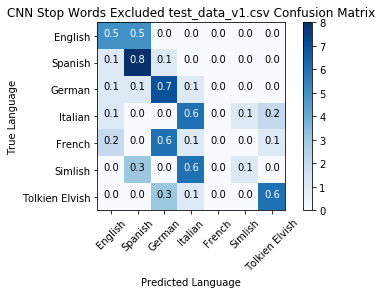

In [49]:
print("CNN Stop Words Excluded -- test_data_v1.csv:") 
test_acc = predict_white_box(stop_words_excluded_cnn, test_data_v1)
print("CNN Stop Words Excluded Accuracy -- test_data_v1.csv:", test_acc)

answers = [x[0] for x in stop_words_excluded_cnn.ans_pred]
predictions = [x[1] for x in stop_words_excluded_cnn.ans_pred]
cnf_matrix = confusion_matrix(answers, predictions)

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=languages, normalize=True,
                      title='CNN Stop Words Excluded test_data_v1.csv Confusion Matrix')

plt.show()

CNN Stop Words Excluded -- test_data_v2.csv:
Word: quit
Actual Language: English
Predicted Language: French
Probability: 0.76898193
Word: damn
Actual Language: English
Predicted Language: English
Probability: 0.6665537
Word: room
Actual Language: English
Predicted Language: English
Probability: 0.6054625
Word: sting
Actual Language: English
Predicted Language: English
Probability: 0.4771995
Word: total
Actual Language: English
Predicted Language: English
Probability: 0.34756446
Word: teach
Actual Language: English
Predicted Language: German
Probability: 0.6093883
Word: change
Actual Language: English
Predicted Language: French
Probability: 0.4957622
Word: absent
Actual Language: English
Predicted Language: German
Probability: 0.5935172
Word: couple
Actual Language: English
Predicted Language: French
Probability: 0.70168805
Word: rainbow
Actual Language: English
Predicted Language: English
Probability: 0.67061245
Word: crystal
Actual Language: English
Predicted Language: German
Probabil

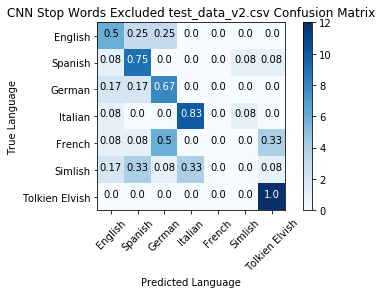

In [50]:
print("CNN Stop Words Excluded -- test_data_v2.csv:") 
test_acc = predict_white_box(stop_words_excluded_cnn, test_data_v2)
print("CNN Stop Words Excluded Accuracy -- test_data_v2.csv:", test_acc)

answers = [x[0] for x in stop_words_excluded_cnn.ans_pred]
predictions = [x[1] for x in stop_words_excluded_cnn.ans_pred]
cnf_matrix = confusion_matrix(answers, predictions)

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=languages, normalize=True,
                      title='CNN Stop Words Excluded test_data_v2.csv Confusion Matrix')

plt.show()

CNN Stop Words Included -- test_data_v1.csv:
Word: recession
Actual Language: English
Predicted Language: French
Probability: 0.7523513
Word: surface
Actual Language: English
Predicted Language: French
Probability: 0.8279157
Word: small
Actual Language: English
Predicted Language: German
Probability: 0.5424717
Word: have
Actual Language: English
Predicted Language: French
Probability: 0.6943667
Word: pedestrian
Actual Language: English
Predicted Language: French
Probability: 0.83604515
Word: notice
Actual Language: English
Predicted Language: French
Probability: 0.7336846
Word: line
Actual Language: English
Predicted Language: French
Probability: 0.5580757
Word: conductor
Actual Language: English
Predicted Language: French
Probability: 0.7572203
Word: federation
Actual Language: English
Predicted Language: French
Probability: 0.7034556
Word: save
Actual Language: English
Predicted Language: French
Probability: 0.66673684
Word: sofá
Actual Language: Spanish
Predicted Language: French
Pr

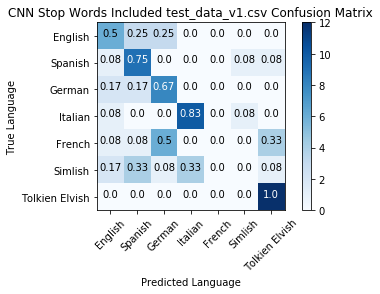

In [51]:
print("CNN Stop Words Included -- test_data_v1.csv:") 
test_acc = predict_white_box(stop_words_included_cnn, test_data_v1)
print("CNN Stop Words Included Accuracy -- test_data_v1.csv:", test_acc)

answers = [x[0] for x in stop_words_excluded_cnn.ans_pred]
predictions = [x[1] for x in stop_words_excluded_cnn.ans_pred]
cnf_matrix = confusion_matrix(answers, predictions)

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=languages, normalize=True,
                      title='CNN Stop Words Included test_data_v1.csv Confusion Matrix')

plt.show()

CNN Stop Words Included -- test_data_v2.csv:
Word: quit
Actual Language: English
Predicted Language: French
Probability: 0.6381659
Word: damn
Actual Language: English
Predicted Language: English
Probability: 0.46303117
Word: room
Actual Language: English
Predicted Language: English
Probability: 0.4604765
Word: sting
Actual Language: English
Predicted Language: German
Probability: 0.60797626
Word: total
Actual Language: English
Predicted Language: French
Probability: 0.6699731
Word: teach
Actual Language: English
Predicted Language: German
Probability: 0.6398898
Word: change
Actual Language: English
Predicted Language: English
Probability: 0.44114816
Word: absent
Actual Language: English
Predicted Language: German
Probability: 0.53575885
Word: couple
Actual Language: English
Predicted Language: French
Probability: 0.77745384
Word: rainbow
Actual Language: English
Predicted Language: German
Probability: 0.58159804
Word: crystal
Actual Language: English
Predicted Language: German
Probabil

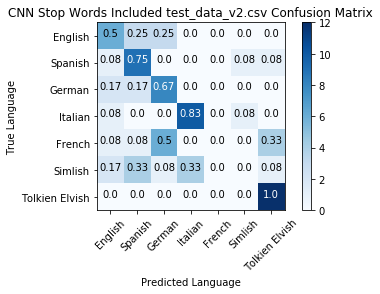

In [52]:
print("CNN Stop Words Included -- test_data_v2.csv:") 
test_acc = predict_white_box(stop_words_included_cnn, test_data_v2)
print("CNN Stop Words Included Accuracy -- test_data_v2.csv:", test_acc)

answers = [x[0] for x in stop_words_excluded_cnn.ans_pred]
predictions = [x[1] for x in stop_words_excluded_cnn.ans_pred]
cnf_matrix = confusion_matrix(answers, predictions)

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=languages, normalize=True,
                      title='CNN Stop Words Included test_data_v2.csv Confusion Matrix')

plt.show()

CNN Difficult Words Included -- test_data_v1.csv:
Word: recession
Actual Language: English
Predicted Language: French
Probability: 0.556273
Word: surface
Actual Language: English
Predicted Language: French
Probability: 0.5469829
Word: small
Actual Language: English
Predicted Language: English
Probability: 0.568583
Word: have
Actual Language: English
Predicted Language: English
Probability: 0.50471556
Word: pedestrian
Actual Language: English
Predicted Language: French
Probability: 0.36602053
Word: notice
Actual Language: English
Predicted Language: French
Probability: 0.4578782
Word: line
Actual Language: English
Predicted Language: French
Probability: 0.47969303
Word: conductor
Actual Language: English
Predicted Language: Spanish
Probability: 0.4654294
Word: federation
Actual Language: English
Predicted Language: Spanish
Probability: 0.4753469
Word: save
Actual Language: English
Predicted Language: French
Probability: 0.5359446
Word: sofá
Actual Language: Spanish
Predicted Language: F

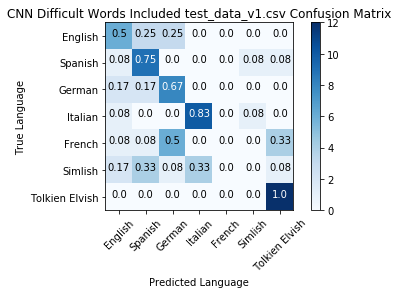

In [53]:
print("CNN Difficult Words Included -- test_data_v1.csv:") 
test_acc = predict_white_box(difficult_words_only_cnn, test_data_v1)
print("CNN Difficult Words Included Accuracy -- test_data_v1.csv:", test_acc)

answers = [x[0] for x in stop_words_excluded_cnn.ans_pred]
predictions = [x[1] for x in stop_words_excluded_cnn.ans_pred]
cnf_matrix = confusion_matrix(answers, predictions)

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=languages, normalize=True,
                      title='CNN Difficult Words Included test_data_v1.csv Confusion Matrix')

plt.show()

CNN Difficult Words Included -- test_data_v2.csv:
Word: quit
Actual Language: English
Predicted Language: French
Probability: 0.44137746
Word: damn
Actual Language: English
Predicted Language: English
Probability: 0.5703012
Word: room
Actual Language: English
Predicted Language: German
Probability: 0.6223139
Word: sting
Actual Language: English
Predicted Language: English
Probability: 0.46996972
Word: total
Actual Language: English
Predicted Language: English
Probability: 0.5761239
Word: teach
Actual Language: English
Predicted Language: English
Probability: 0.5269832
Word: change
Actual Language: English
Predicted Language: English
Probability: 0.5113454
Word: absent
Actual Language: English
Predicted Language: English
Probability: 0.5600322
Word: couple
Actual Language: English
Predicted Language: French
Probability: 0.5408641
Word: rainbow
Actual Language: English
Predicted Language: English
Probability: 0.5781662
Word: crystal
Actual Language: English
Predicted Language: English
Pr

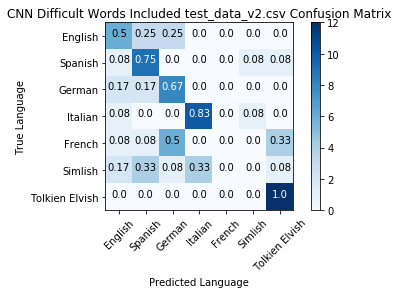

In [54]:
print("CNN Difficult Words Included -- test_data_v2.csv:") 
test_acc = predict_white_box(difficult_words_only_cnn, test_data_v2)
print("CNN Stop Words Included Accuracy -- test_data_v2.csv:", test_acc)

answers = [x[0] for x in stop_words_excluded_cnn.ans_pred]
predictions = [x[1] for x in stop_words_excluded_cnn.ans_pred]
cnf_matrix = confusion_matrix(answers, predictions)

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=languages, normalize=True,
                      title='CNN Difficult Words Included test_data_v2.csv Confusion Matrix')

plt.show()